In [5]:
import pandas as pd
df = pd.read_csv("imdb_top_1000.csv")
print(df.shape)
print(df.columns.tolist())
print(df.info())
print(df.isnull().sum().sort_values(ascending=False))
df.head()

(1000, 16)
['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate', 'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 n

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [8]:
import numpy as np
df = pd.read_csv("imdb_top_1000.csv")
df['Year_clean'] = df['Released_Year'].astype(str).str.extract(r'(\d{4})').astype('Int64')
df['Runtime_min'] = df['Runtime'].astype(str).str.extract(r'(\d+)').astype('Int64')
def parse_gross(x):
    if pd.isna(x):
      return np.nan
    s = str(x).replace(',','').replace(' ','')
    s = s.replace('$','')
    if 'M' in s:
        return float(s.replace('M','')) * 1e6
    if 'K' in s:
        return float(s.replace('K','')) * 1e3
    try:
        return float(s)
    except:
        return np.nan

df['Gross_num'] = df['Gross'].apply(parse_gross)

In [9]:
# Primary (first) genre
df['Primary_Genre'] = df['Genre'].fillna('Unknown').apply(lambda s: str(s).split(',')[0].strip())

# Keep top N genres, group rest to "Other"
top_genres = df['Primary_Genre'].value_counts().nlargest(8).index.tolist()
df['Genre_agg'] = df['Primary_Genre'].apply(lambda g: g if g in top_genres else 'Other')

# one-hot encode
genre_dummies = pd.get_dummies(df['Genre_agg'], prefix='genre')

# fill Meta_score
df['Meta_score_filled'] = df['Meta_score'].fillna(df['Meta_score'].median())

# assemble features
features = pd.concat([df[['Meta_score_filled','No_of_Votes','Runtime_min','Year_clean']].reset_index(drop=True),
                      genre_dummies.reset_index(drop=True)], axis=1)

In [12]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.8 MB/s eta 0:00:00


In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

df['overview_compound'] = df['Overview'].fillna("").apply(lambda t: analyzer.polarity_scores(t)['compound'])
df['overview_sentiment'] = df['overview_compound'].apply(
    lambda c: 'pos' if c > 0.05 else ('neg' if c < -0.05 else 'neu')
)

In [14]:
# select rows with no missing features
mask = features.notnull().all(axis=1) & df['IMDB_Rating'].notnull()
X = features[mask]
y = df.loc[mask, 'IMDB_Rating']

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test R2:", r2_score(y_test, y_pred))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
# cross validation for stable estimate
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("5-fold CV R2 mean:", cv_scores.mean())

Test R2: 0.3952002863688431
Test MAE: 0.15472749999999957
5-fold CV R2 mean: -14.828771865680125


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor

num_cols = ['Meta_score_filled','No_of_Votes','Runtime_min','Year_clean']
cat_cols = ['Genre_agg']
text_col = 'Overview'

numeric_pipeline = Pipeline([('scaler', StandardScaler())])
cat_pipeline = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])
text_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=5000)),
                          ('svd', TruncatedSVD(n_components=50, random_state=42))])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
    ('txt', text_pipeline, text_col)
])

full_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42))
])

In [17]:
pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 34.4 MB/s eta 0:00:00


In [19]:
joblib.dump(model, 'movie_model.joblib')

['movie_model.joblib']

In [20]:
import streamlit as st
import joblib
model = joblib.load('movie_model.joblib')
# UI for input -> model.predict(...)

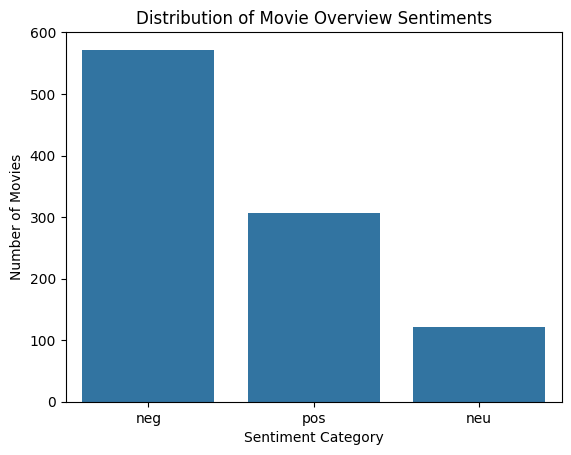

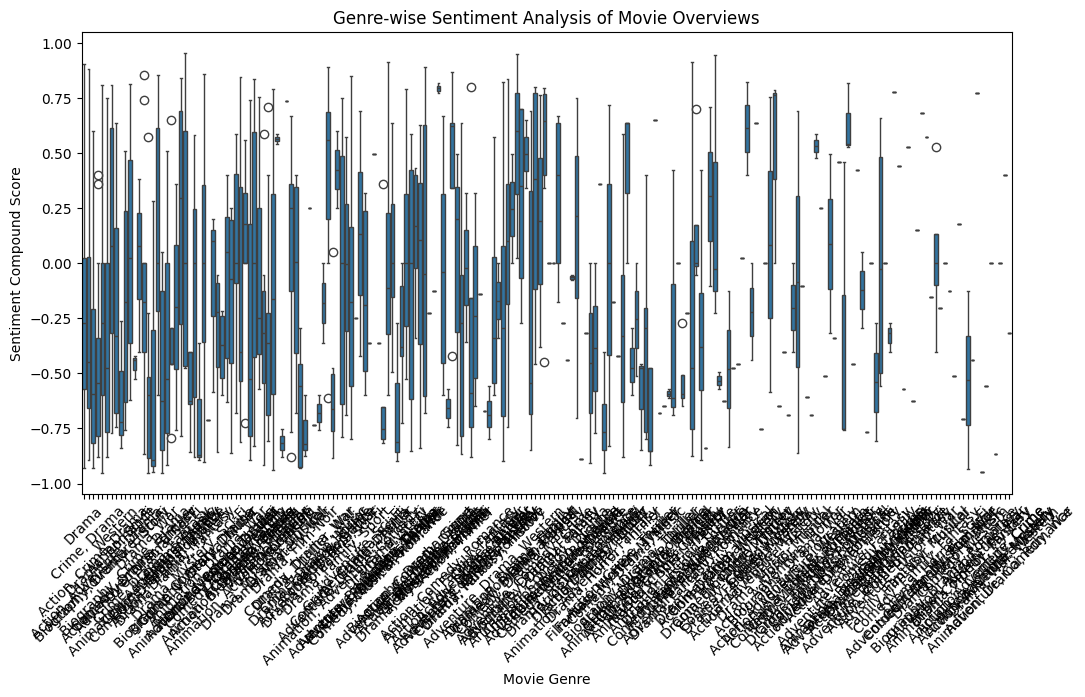

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count of sentiment categories from movie overviews
sns.countplot(data=df, x='overview_sentiment')
plt.title("Distribution of Movie Overview Sentiments")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Movies")
plt.show()

# Boxplot of sentiment scores across genres
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Genre', y='overview_compound')
plt.title("Genre-wise Sentiment Analysis of Movie Overviews")
plt.xlabel("Movie Genre")
plt.ylabel("Sentiment Compound Score")
plt.xticks(rotation=45)
plt.show()


<Axes: xlabel='Main_Genre', ylabel='overview_compound'>

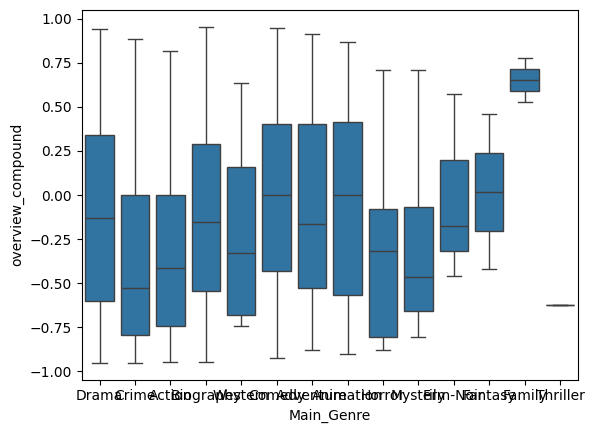

In [23]:
df['Main_Genre'] = df['Genre'].apply(lambda x: x.split(',')[0].strip())
sns.boxplot(data=df, x='Main_Genre', y='overview_compound')

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Select required columns and drop NaN rows
model_df = df[['IMDB_Rating', 'No_of_Votes', 'overview_compound', 'Gross_num']].dropna()

# Define features and target
X = model_df[['IMDB_Rating', 'No_of_Votes', 'overview_compound']]
y = model_df['Gross_num']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
model_df.isna().sum()

R² Score: 0.4908426844530571
Mean Absolute Error (MAE): 55813473.58662563


,0
IMDB_Rating,0
No_of_Votes,0
overview_compound,0
Gross_num,0


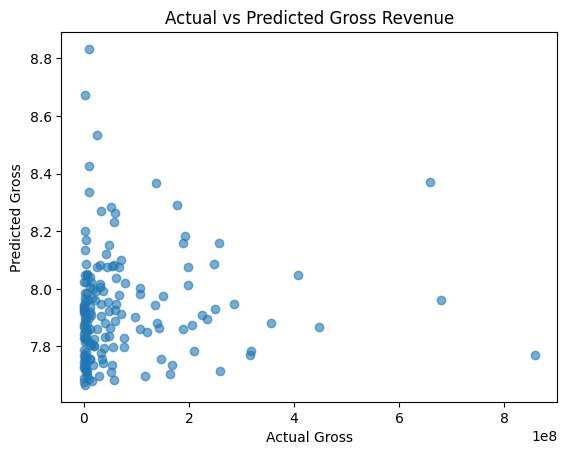

In [25]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Gross")
plt.ylabel("Predicted Gross")
plt.title("Actual vs Predicted Gross Revenue")
plt.show()

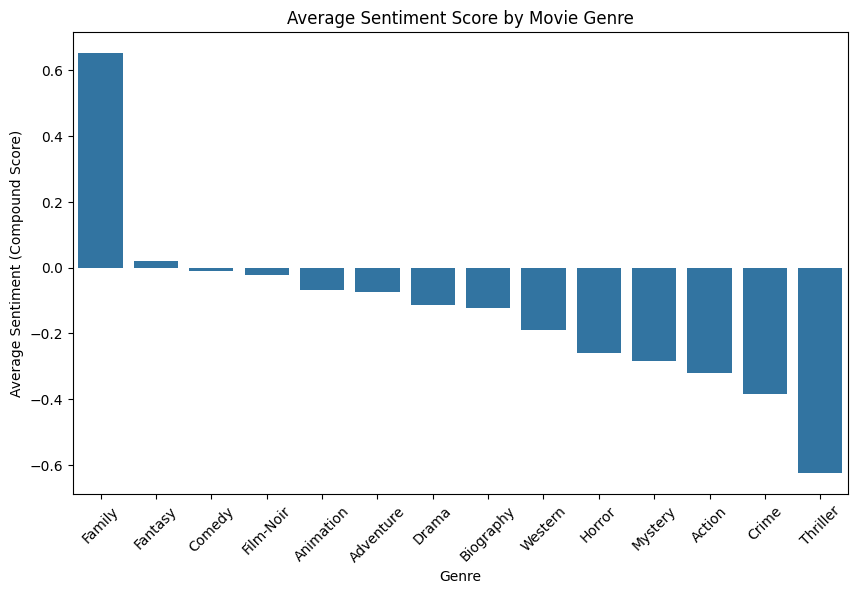

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# If a movie has multiple genres (e.g., "Action, Adventure, Sci-Fi"),
# we take only the first one for clarity
df['Main_Genre'] = df['Genre'].apply(lambda x: x.split(',')[0].strip() if isinstance(x, str) else x)

# Group by main genre and compute average sentiment score
genre_sentiment = df.groupby('Main_Genre')['overview_compound'].mean().reset_index()

# Sort by sentiment for better visualization
genre_sentiment = genre_sentiment.sort_values(by='overview_compound', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=genre_sentiment, x='Main_Genre', y='overview_compound')
plt.title("Average Sentiment Score by Movie Genre")
plt.xlabel("Genre")
plt.ylabel("Average Sentiment (Compound Score)")
plt.xticks(rotation=45)
plt.show()

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

clean_df = df.copy()

excel_path = "IMDB_Cleaned_Analysis.xlsx"
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    clean_df.to_excel(writer, index=False, sheet_name='Cleaned_Data')

print(f"✅ Cleaned dataset exported successfully to {excel_path}")

✅ Cleaned dataset exported successfully to IMDB_Cleaned_Analysis.xlsx


In [30]:
# Create a folder for graph images
import os
if not os.path.exists("graphs"):
    os.mkdir("graphs")

# Example Graph 1: Sentiment Distribution
plt.figure()
sns.countplot(data=df, x='overview_sentiment')
plt.title("Distribution of Movie Overview Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.savefig("graphs/sentiment_distribution.png", bbox_inches='tight')

# Example Graph 2: Genre-wise Sentiment
plt.figure(figsize=(10,6))
sns.barplot(data=genre_sentiment, x='Main_Genre', y='overview_compound')
plt.title("Average Sentiment Score by Movie Genre")
plt.xticks(rotation=45)
plt.savefig("graphs/genre_sentiment.png", bbox_inches='tight')

# Example Graph 3: Actual vs Predicted Gross
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Gross")
plt.ylabel("Predicted Gross")
plt.title("Actual vs Predicted Gross Revenue")
plt.savefig("graphs/predicted_vs_actual.png", bbox_inches='tight')

plt.close('all')  # Close all plots
print("Graphs saved as PNG images in the 'graphs' folder.")

Graphs saved as PNG images in the 'graphs' folder.


In [31]:
from openpyxl import load_workbook
from openpyxl.drawing.image import Image

wb = load_workbook(excel_path)
ws = wb.create_sheet("Graphs")

# Add the images
img1 = Image("graphs/sentiment_distribution.png")
img2 = Image("graphs/genre_sentiment.png")
img3 = Image("graphs/predicted_vs_actual.png")

ws.add_image(img1, "A1")
ws.add_image(img2, "A25")
ws.add_image(img3, "A50")

wb.save(excel_path)
print(f"✅ All graphs embedded and saved to {excel_path}")


✅ All graphs embedded and saved to IMDB_Cleaned_Analysis.xlsx
